# Traffic Sign Recognition with Tensorflow

## import the needed libraries and get that out of the way.

In [1]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import color

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.optimizers import RMSprop

# Allow image embeding in notebook
%matplotlib inline

Using TensorFlow backend.


## Trainging Dataset

We're using the Belgian Traffic Sign Dataset. Go to http://btsd.ethz.ch/shareddata/ and download the training and test data. There is a lot of datasets on that page, but you only need the two files listed under **BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

After downloading and expanding the files, your directory structure should look something like this:

```
data/Training/
data/Testing/
```

Each of the two directories above has 62 sub-directories named sequentially from 00000 to 00062. The directory name represents the code (or label) and the images inside the directory are examples of that label. 

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "/home/wang/PycharmProjects/traffic_sign_classifier /data"
train_data_dir = os.path.join(ROOT_PATH, "Training")
test_data_dir = os.path.join(ROOT_PATH, "Testing")

images, labels = load_data(train_data_dir)

Here we're loading two lists:
* **images** a list of images, each image is represted by a numpy array.
* **labels** a list of labels. Integers with values between 0 and 61.


It's not usually a good idea to load the whole dataset into memory, but this dataset is small and we're trying to keep the code simple, so it's okay for now. We'll improve it in the next part. For larger datasets, we'd want to have a separate thread loading chunks of data in the background and feeding them to the training thread. 

## Explore the Dataset

How many images and labels do we have?

In [3]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels)), len(images)))

Unique Labels: 62
Total Images: 4575


Display the first image of each label.

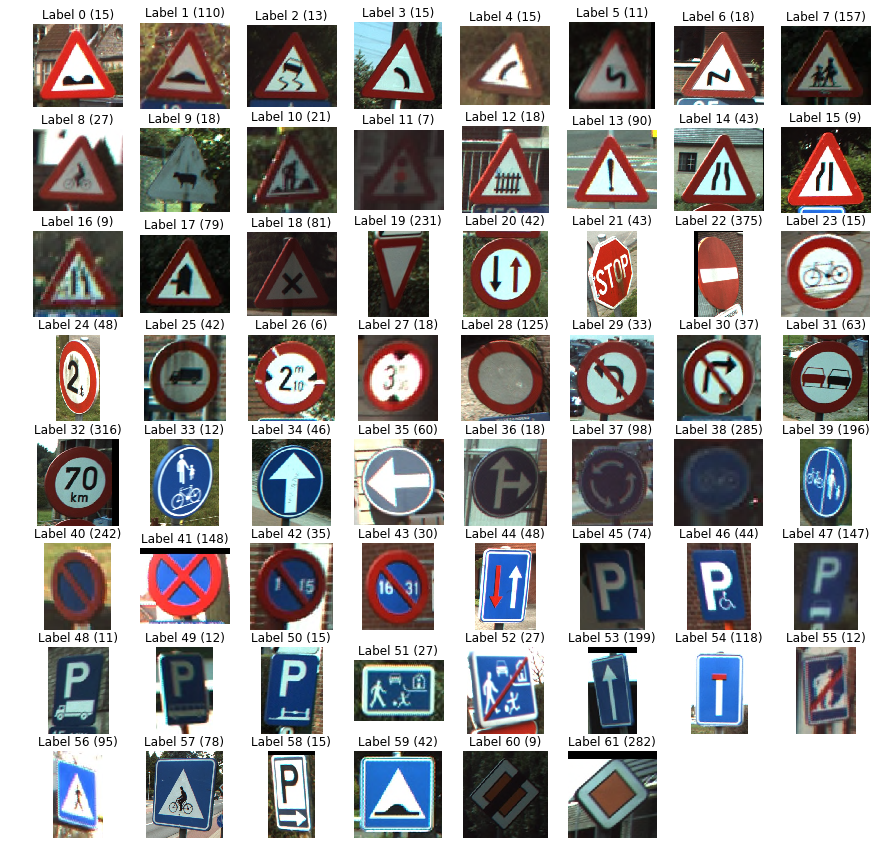

In [4]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images, labels)

## Resize图片

大多数神经网络需要一个固定大小的输入。但正如上面我们看到的,我们的图片不都是一样的尺寸。我们使用一个简单的方法进行处理，直接将图片resize成相同的尺寸。


/home/wang/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/wang/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


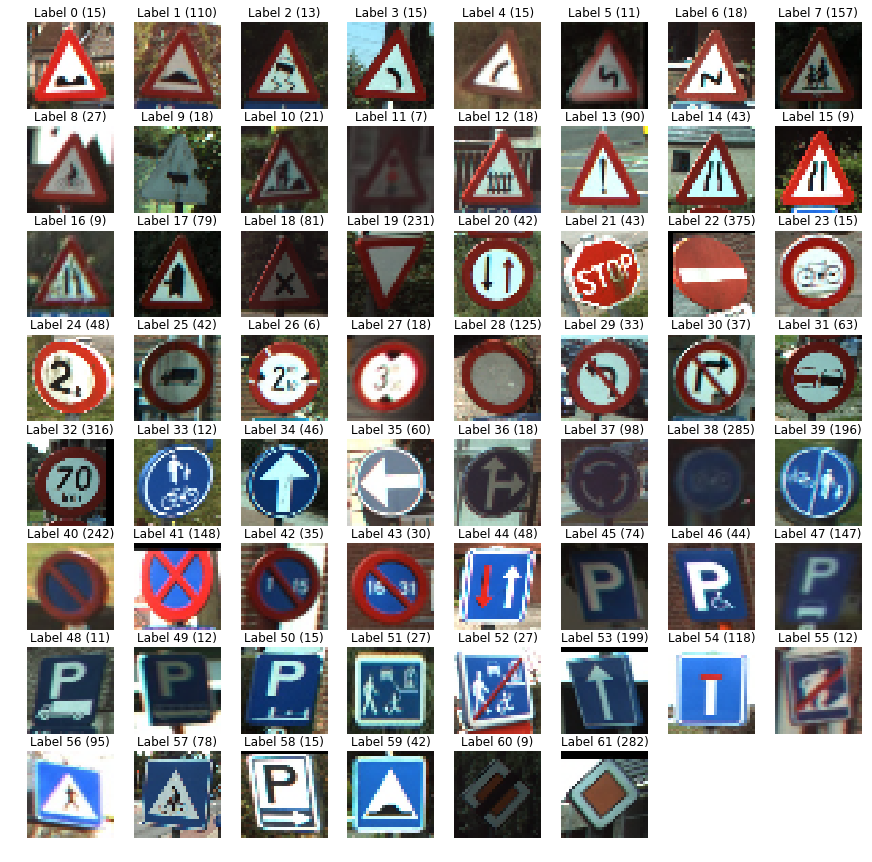

In [5]:
# Resize images
images32 = [skimage.transform.resize(image, (32, 32))
                for image in images]
display_images_and_labels(images32, labels)

虽然图像被缩小至32x32但是对人来说仍然可以识别。

In [6]:
for image in images32[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.123324525123, max: 1.0
shape: (32, 32, 3), min: 0.0900505514706, max: 1.0
shape: (32, 32, 3), min: 0.0411908318015, max: 0.993856272978
shape: (32, 32, 3), min: 0.0717524509804, max: 1.0
shape: (32, 32, 3), min: 0.0987649356618, max: 1.0


图像的像素点值已经被归一化了（0～1）

## 将图像转为numpy array

In [7]:
labels_a = np.array(labels)
images_a = np.array(images32)
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (4575,), '\nimages: ', (4575, 32, 32, 3))


## 将图像转为灰度图
对图像进行一定的预处理，在本例中，我们将原来的RGB三通道的图像转换为灰度图

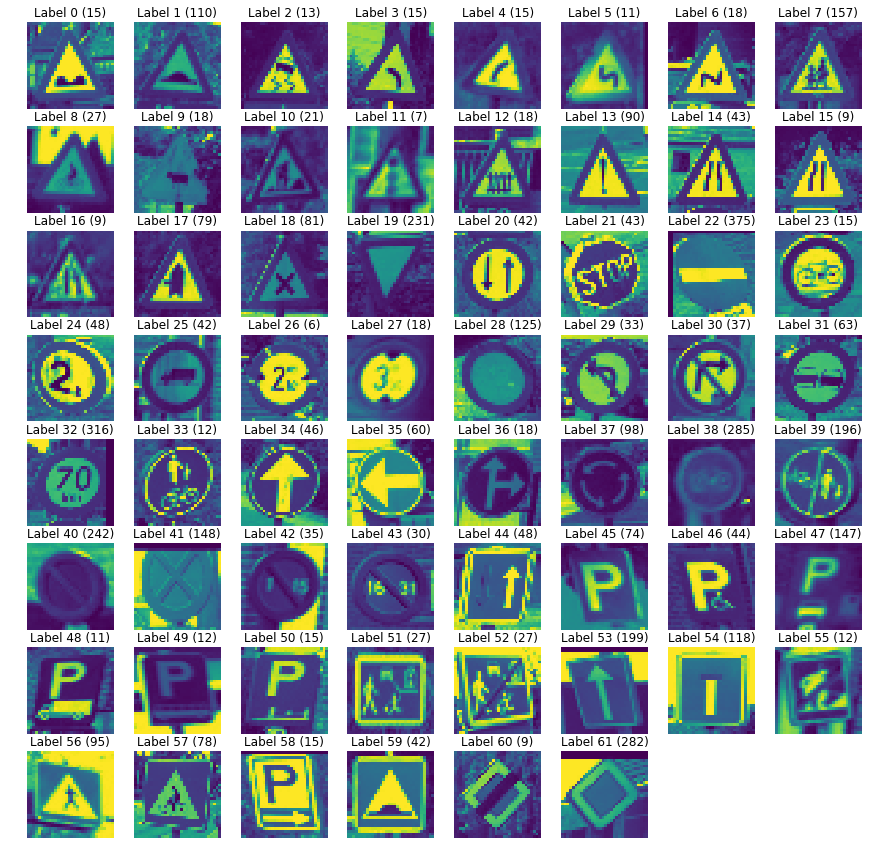

In [8]:
images_a = color.rgb2gray(images_a)
display_images_and_labels(images_a, labels)

In [9]:
print("labels: ", labels_a.shape, "\nimages: ", images_a.shape)

('labels: ', (4575,), '\nimages: ', (4575, 32, 32))


## 数据集增强，通过随机的平移和旋转扩充数据

In [10]:
def expend_training_data(train_x, train_y):
    """
    Augment training data
    """
    expanded_images = np.zeros([train_x.shape[0] * 5, train_x.shape[1], train_x.shape[2]])
    expanded_labels = np.zeros([train_x.shape[0] * 5])

    counter = 0
    for x, y in zip(train_x, train_y):

        # register original data
        expanded_images[counter, :, :] = x
        expanded_labels[counter] = y
        counter = counter + 1

        # get a value for the background
        # zero is the expected value, but median() is used to estimate background's value
        bg_value = np.median(x)  # this is regarded as background's value

        for i in range(4):
            # rotate the image with random degree
            angle = np.random.randint(-15, 15, 1)
            new_img = ndimage.rotate(x, angle, reshape=False, cval=bg_value)

            # shift the image with random distance
            shift = np.random.randint(-2, 2, 2)
            new_img_ = ndimage.shift(new_img, shift, cval=bg_value)

            # register new training data
            expanded_images[counter, :, :] = new_img_
            expanded_labels[counter] = y
            counter = counter + 1

    return expanded_images, expanded_labels

images_a, labels_a = expend_training_data(images_a, labels_a)
print(images_a.shape, labels_a.shape)
labels = labels_a.tolist()
print(len(labels))

((22875, 32, 32), (22875,))
22875


训练集被扩充为原来的5倍，下面我们展示几个样本

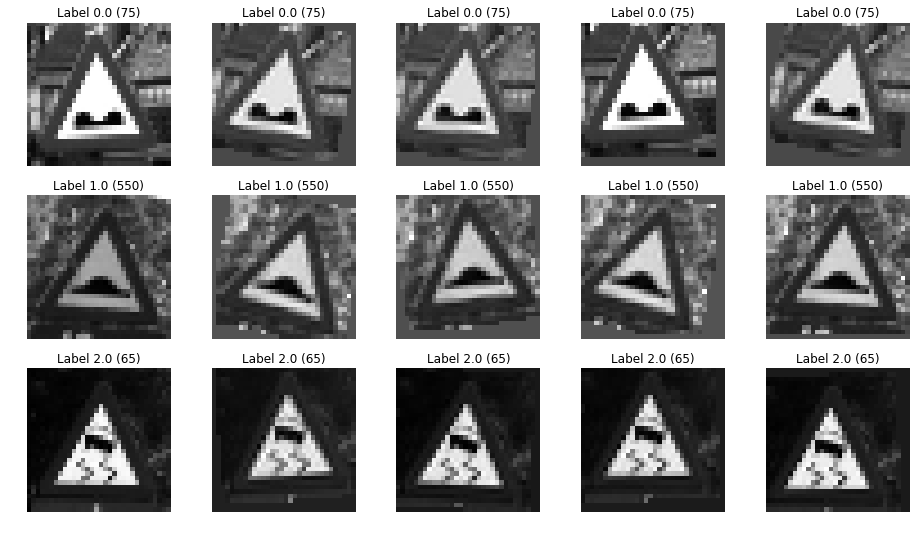

In [11]:
def plot_agument(images, labels):
    plt.figure(figsize=(16, 9))
    unique_labels = set(labels)
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        if i > 3:
            break
        img_index = labels.index(label)
        for j in range(5):
            image = images_a[img_index+j]
            plt.subplot(3, 5, (i-1)*5 + j+1)  # A grid of 8 rows x 8 columns
            plt.axis('off')
            plt.title("Label {0} ({1})".format(label, labels.count(label)))
            _ = plt.imshow(image, cmap='gray')
        i += 1

plot_agument(images_a, labels)

In [12]:
from sklearn.utils import shuffle

indx = np.arange(0, len(labels_a))
indx = shuffle(indx)
images_a = images_a[indx]
labels_a = labels_a[indx]

print(images_a.shape, labels_a.shape)

((22875, 32, 32), (22875,))


In [13]:
train_x, val_x = images_a[:20000], images_a[20000:]
train_y, val_y = labels_a[:20000], labels_a[20000:]

train_y = keras.utils.to_categorical(train_y, 62)
val_y = keras.utils.to_categorical(val_y, 62)
print(train_x.shape, train_y.shape)

((20000, 32, 32), (20000, 62))


In [14]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(62, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=20,
                    verbose=1,
                    validation_data=(val_x, val_y))

### print the keys contained in the history object
print(history.history.keys())
model.save('traffic_model.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 62)                31806     
Total params: 819,262
Trainable params: 819,262
Non-trainable params: 0
_________________________________________________________________
Trai

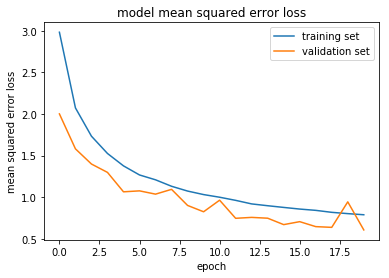

In [15]:
def plot_training(history):
    ### plot the training and validation loss for each epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()

plot_training(history=history)

In [ ]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
# Transform the images, just like we did with the training set.
test_images32 = [skimage.transform.resize(image, (32, 32))
                 for image in test_images]

test_images_a = np.array(test_images32)
test_labels_a = np.array(test_labels)

test_images_a = color.rgb2gray(test_images_a)

display_images_and_labels(test_images_a, test_labels)

In [ ]:
test_x = test_images_a
test_y = keras.utils.to_categorical(test_labels_a, 62)
score = model.evaluate(test_x, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [22]:
predicted = model.predict(test_x)
predicted = np.argmax(predicted, 1)
print(predicted.shape)

(2520,)


## Using the Model

展示几个样本的预测结果

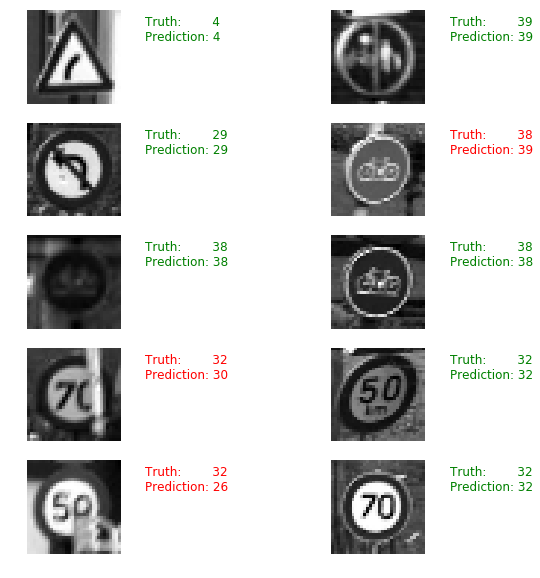

In [23]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
j = 1
for i in range(0, 1000, 100):
    truth = test_labels_a[i]
    prediction = predicted[i]
    plt.subplot(5, 2, j)
    j = j+1 
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
             fontsize=12, color=color)
    plt.imshow(test_x[i], cmap='gray')
